# Preparing Data from the MIMIC-III Database
In preparation of predicting hospital readmissions, data from the NOTEVENTS and ADMISSIONS tables of the MIMIC-III database will be pulled into a pandas DataFrame and cleaned.

In [1]:
# import libraries
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table

%matplotlib inline
%load_ext watermark

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%watermark -a "E. Chris Lynch" -d -t -v -p numpy,pandas,matplotlib,sqlalchemy

E. Chris Lynch 2018-12-19 21:11:28 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
matplotlib 2.2.3
sqlalchemy 1.2.15


In [3]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

database_url = os.environ.get("DATABASE_URL")

In [4]:
# initiate PostgreSQL engine
engine = create_engine(database_url,
    connect_args={'options': '-csearch_path=mimiciii'}
)
connection = engine.connect()

In [5]:
metadata = MetaData()

# define NOTEEVENTS table
notes = Table('noteevents', metadata, autoload=True, autoload_with=engine)

In [6]:
# Print the column names
print('COLUMN NAMES')
print(notes.columns.keys())

# Print full table metadata
print('\nMETADATA')
print(repr(notes))

COLUMN NAMES
['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime', 'storetime', 'category', 'description', 'cgid', 'iserror', 'text']

METADATA
Table('noteevents', MetaData(bind=None), Column('row_id', INTEGER(), table=<noteevents>, primary_key=True, nullable=False), Column('subject_id', INTEGER(), table=<noteevents>, nullable=False), Column('hadm_id', INTEGER(), table=<noteevents>), Column('chartdate', TIMESTAMP(precision=0), table=<noteevents>), Column('charttime', TIMESTAMP(precision=0), table=<noteevents>), Column('storetime', TIMESTAMP(precision=0), table=<noteevents>), Column('category', VARCHAR(length=50), table=<noteevents>), Column('description', VARCHAR(length=255), table=<noteevents>), Column('cgid', INTEGER(), table=<noteevents>), Column('iserror', CHAR(length=1), table=<noteevents>), Column('text', TEXT(), table=<noteevents>), schema=None)


In [7]:
# return a count of records by category
query = 'SELECT COUNT(row_id) as Count, category \
        FROM noteevents \
        GROUP BY category \
        ORDER BY Count DESC'
cat_counts = connection.execute(query).fetchall()
for count, cat in cat_counts:
    print('{0}: {1}'.format(cat, count))

Nursing/other: 822497
Radiology: 522279
Nursing: 223556
ECG: 209051
Physician : 141624
Discharge summary: 59652
Echo: 45794
Respiratory : 31739
Nutrition: 9418
General: 8301
Rehab Services: 5431
Social Work: 2670
Case Management : 967
Pharmacy: 103
Consult: 98


## Extract data from ADMISSIONS table

In [8]:
# define ADMISSIONS table
admit = Table('admissions', metadata, autoload=True, autoload_with=engine)

# Print the column names
print('COLUMN NAMES')
print(admit.columns.keys())

# Print full table metadata
print('\nMETADATA')
print(repr(admit))

COLUMN NAMES
['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data']

METADATA
Table('admissions', MetaData(bind=None), Column('row_id', INTEGER(), table=<admissions>, primary_key=True, nullable=False), Column('subject_id', INTEGER(), table=<admissions>, nullable=False), Column('hadm_id', INTEGER(), table=<admissions>, nullable=False), Column('admittime', TIMESTAMP(precision=0), table=<admissions>, nullable=False), Column('dischtime', TIMESTAMP(precision=0), table=<admissions>, nullable=False), Column('deathtime', TIMESTAMP(precision=0), table=<admissions>), Column('admission_type', VARCHAR(length=50), table=<admissions>, nullable=False), Column('admission_location', VARCHAR(length=50), table=<admissions>, nullable=False), Column('discharge_location', VA

In [9]:
# extract Admissions data
query = "SELECT subject_id, hadm_id, admittime, dischtime, deathtime, admission_type FROM admissions"
admissions_query = connection.execute(query).fetchall()

In [10]:
# create DataFrame
admissions_df = pd.DataFrame.from_records(admissions_query, 
                                         columns=['subject_id', 'hadm_id', 'admission_time',
                                                  'discharge_time','time_of_death','admission_type'])
admissions_df.head(3)

,subject_id,hadm_id,admission_time,discharge_time,time_of_death,admission_type
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY


In [11]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 6 columns):
subject_id        58976 non-null int64
hadm_id           58976 non-null int64
admission_time    58976 non-null datetime64[ns]
discharge_time    58976 non-null datetime64[ns]
time_of_death     5854 non-null datetime64[ns]
admission_type    58976 non-null object
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 2.7+ MB


In [12]:
# sort by subject_ID and admission time
admissions_df = admissions_df.sort_values(['subject_id','admission_time'])
admissions_df = admissions_df.reset_index(drop=True)

In [13]:
# add the next admission date and type for each subject
admissions_df['next_admission'] = admissions_df.groupby('subject_id').admission_time.shift(-1)

# get the next admission type
admissions_df['next_admission_type'] = admissions_df.groupby('subject_id').admission_type.shift(-1)

In [14]:
# get rows where next admission is elective and replace with naT or nan
rows = admissions_df.next_admission_type == 'ELECTIVE'
admissions_df.loc[rows,'next_admission'] = pd.NaT
admissions_df.loc[rows,'next_admission_type'] = np.NaN

In [15]:
# sort by subject_ID and admission date
admissions_df = admissions_df.sort_values(['subject_id','admission_time'])

# back fill next admission type
admissions_df[['next_admission','next_admission_type']] = admissions_df.groupby(['subject_id'])[['next_admission','next_admission_type']].fillna(method = 'bfill')

In [16]:
# calculate the number of days between admissions
admissions_df['days_between_admit']=  (admissions_df.next_admission - admissions_df.discharge_time).dt.total_seconds()/(24*60*60)

In [17]:
admissions_df.head(3)

,subject_id,hadm_id,admission_time,discharge_time,time_of_death,admission_type,next_admission,next_admission_type,days_between_admit
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN


In [18]:
# assert there are no duplicate hospital admissions
assert admissions_df.duplicated(['hadm_id']).sum() == 0, 'Multiple admissions per ID'

In [19]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 9 columns):
subject_id             58976 non-null int64
hadm_id                58976 non-null int64
admission_time         58976 non-null datetime64[ns]
discharge_time         58976 non-null datetime64[ns]
time_of_death          5854 non-null datetime64[ns]
admission_type         58976 non-null object
next_admission         11399 non-null datetime64[ns]
next_admission_type    11399 non-null object
days_between_admit     11399 non-null float64
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 4.5+ MB


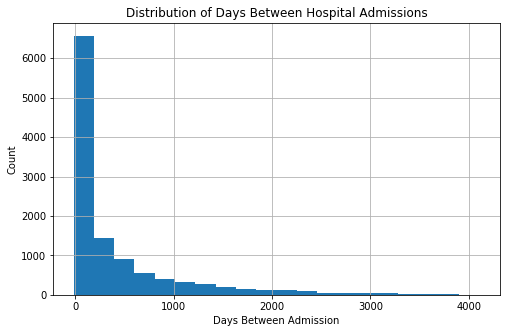

In [194]:
fig, ax = plt.subplots(figsize=(8,5))
admissions_df.days_between_admit.hist(bins=20, ax=ax)
ax.set_title('Distribution of Days Between Hospital Admissions')
ax.set_xlabel('Days Between Admission')
ax.set_ylabel('Count')
plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                         'figures','days_between_distro.png'))

## Extract Discharge Summary notes from NOTEEVENTS table

In [25]:
# define NOTEEVENTES table
notes = Table('noteevents', metadata, autoload=True, autoload_with=engine)

# Print the column names
print('COLUMN NAMES')
print(notes.columns.keys())

# Print full table metadata
print('\nMETADATA')
print(repr(notes))

COLUMN NAMES
['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime', 'storetime', 'category', 'description', 'cgid', 'iserror', 'text']

METADATA
Table('noteevents', MetaData(bind=None), Column('row_id', INTEGER(), table=<noteevents>, primary_key=True, nullable=False), Column('subject_id', INTEGER(), table=<noteevents>, nullable=False), Column('hadm_id', INTEGER(), table=<noteevents>), Column('chartdate', TIMESTAMP(precision=0), table=<noteevents>), Column('charttime', TIMESTAMP(precision=0), table=<noteevents>), Column('storetime', TIMESTAMP(precision=0), table=<noteevents>), Column('category', VARCHAR(length=50), table=<noteevents>), Column('description', VARCHAR(length=255), table=<noteevents>), Column('cgid', INTEGER(), table=<noteevents>), Column('iserror', CHAR(length=1), table=<noteevents>), Column('text', TEXT(), table=<noteevents>), schema=None)


### Dataframe with Nursing and Discharge Summary Notes

In [41]:
# extract Discharge and Nursing notes
query = "SELECT subject_id, hadm_id, category, text \
        FROM noteevents \
        WHERE category = 'Discharge summary' OR category = 'Nursing'"
nurse_discharge_query = connection.execute(query).fetchall()

In [157]:
# create DataFrame
nurse_discharge_df = pd.DataFrame.from_records(nurse_discharge_query, 
                                         columns=['subject_id','hadm_id','category','text'])
print(nurse_discharge_df.shape)
nurse_discharge_df.head(3)

(283208, 4)


,subject_id,hadm_id,category,text
0,75201,167242.0,Nursing,TITLE:\n 67 y.o.m. with metastatic renal cel...
1,85264,115648.0,Nursing,TITLE:\n Code status : DNI.\n Contact pers...
2,29431,114252.0,Nursing,TITLE:\n .H/O epiduarl abscess\n Assessmen...


In [158]:
# drop duplicate notes
nurse_discharge_df.drop_duplicates(subset=['hadm_id','text'], inplace=True)
print(nurse_discharge_df.shape)

(260466, 4)


In [159]:
# group by admissions and concat notes as a list
grouped_df = nurse_discharge_df.groupby(['subject_id','hadm_id'])['text'].apply(list).to_frame().reset_index()

In [160]:
grouped_df.head()

,subject_id,hadm_id,text
0,3,145834.0,[Admission Date: [**2101-10-20**] Dischar...
1,4,185777.0,[Admission Date: [**2191-3-16**] Discharg...
2,6,107064.0,[Admission Date: [**2175-5-30**] Discha...
3,9,150750.0,[Admission Date: [**2149-11-9**] Discha...
4,10,184167.0,[Admission Date: [**2103-6-28**] Discha...


In [161]:
assert grouped_df.duplicated(['hadm_id']).sum() == 0, 'Multiple discharge summaries per admission'

In [162]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52993 entries, 0 to 52992
Data columns (total 3 columns):
subject_id    52993 non-null int64
hadm_id       52993 non-null float64
text          52993 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


## Merge Admissions and Nursing/Discharge Summary DataFrames

In [164]:
full_df = pd.merge(admissions_df[['subject_id','hadm_id','admission_time','discharge_time','next_admission','days_between_admit','admission_type','time_of_death']],
                        grouped_df[['subject_id','hadm_id','text']], 
                        on = ['subject_id','hadm_id'],
                        how = 'left')

assert len(full_df) == len(admissions_df)

In [165]:
full_df.head()

,subject_id,hadm_id,admission_time,discharge_time,next_admission,days_between_admit,admission_type,time_of_death,text
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NaN,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,NaN,EMERGENCY,NaT,[Admission Date: [**2101-10-20**] Dischar...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,NaN,EMERGENCY,NaT,[Admission Date: [**2191-3-16**] Discharg...
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NaN,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaN,ELECTIVE,NaT,[Admission Date: [**2175-5-30**] Discha...


In [166]:
assert len(full_df[full_df.discharge_time == np.datetime64('NaT')]) == 0, 'Missing discharge time info'

In [168]:
perc_missing = full_df.text.isna().sum() / len(full_df) * 100
print('{:.2f}% of text cells are empty.'.format(perc_missing))
print('-'*40)
for adm_type in full_df.admission_type.unique():
    txt_missing = full_df[full_df.admission_type == adm_type].text.isna().sum() / len(full_df[full_df.admission_type == adm_type]) * 100
    print('{:.2f}% of {} text cells are empty.'.format(txt_missing, adm_type))

10.14% of text cells are empty.
----------------------------------------
53.67% of NEWBORN text cells are empty.
3.24% of EMERGENCY text cells are empty.
4.49% of ELECTIVE text cells are empty.
4.12% of URGENT text cells are empty.


In [169]:
# drop NEWBORN admissions
clean_df = full_df[full_df.admission_type != 'NEWBORN'].copy()

In [170]:
# add target variable
clean_df['readmission'] = (clean_df.days_between_admit < 30).astype('int')

In [171]:
clean_df.head()

,subject_id,hadm_id,admission_time,discharge_time,next_admission,days_between_admit,admission_type,time_of_death,text,readmission
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,NaN,EMERGENCY,NaT,[Admission Date: [**2101-10-20**] Dischar...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,NaN,EMERGENCY,NaT,[Admission Date: [**2191-3-16**] Discharg...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaN,ELECTIVE,NaT,[Admission Date: [**2175-5-30**] Discha...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,NaT,NaN,EMERGENCY,2149-11-14 10:15:00,[Admission Date: [**2149-11-9**] Discha...,0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,NaN,EMERGENCY,NaT,[Admission Date: [**2178-4-16**] ...,0


In [172]:
# save file to CSV
clean_df.to_csv(PROJ_ROOT + '/data/processed/clinic_notes_data.csv')

5.88% of samples are in positive class


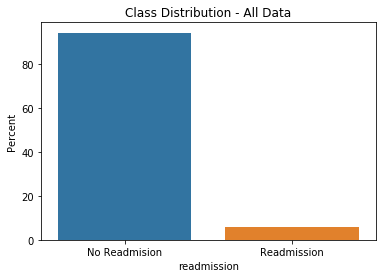

In [173]:
# plot the distribution of positive and negative samples
ax = sns.barplot(x='readmission', y='readmission',data=clean_df, estimator=lambda x: len(x) / len(clean_df.readmission) * 100)
ax.set_ylabel("Percent")
ax.set_xticklabels(["No Readmision","Readmission"])
ax.set_title('Class Distribution - All Data')
plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                         'figures','class_balance.png'))

# compute percentage of samples who were readmitted within 30 days (positive)
pos_perc = clean_df.readmission.sum() / len(clean_df.readmission) * 100
print('{:.2f}% of samples are in positive class'.format(pos_perc))

## Split Data into Train and Test Sets

In [261]:
# shuffle the samples
clean_df = clean_df.sample(n = len(clean_df), random_state=42)
clean_df.reset_index(drop=True, inplace=True)

# Save 30% of the data as test a test set 
clinic_test = clean_df.sample(frac=0.30, random_state=42)

# use the rest of the data as training data
clinic_train = clean_df.drop(clinic_test.index)

In [262]:
clinic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35779 entries, 0 to 51112
Data columns (total 10 columns):
subject_id            35779 non-null int64
hadm_id               35779 non-null int64
admission_time        35779 non-null datetime64[ns]
discharge_time        35779 non-null datetime64[ns]
next_admission        7821 non-null datetime64[ns]
days_between_admit    7821 non-null float64
admission_type        35779 non-null object
time_of_death         4091 non-null datetime64[ns]
text                  34527 non-null object
readmission           35779 non-null int32
dtypes: datetime64[ns](4), float64(1), int32(1), int64(2), object(2)
memory usage: 2.9+ MB


Check to make sure we did not lose too much of the positive class while splitting the data.

6.02% of samples are in positive class


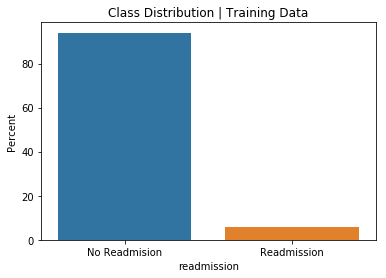

In [263]:
# plot class distribution of training set
ax = sns.barplot(x='readmission', y='readmission', data=clinic_train, 
                 estimator=lambda x: len(x) / len(clinic_train.readmission) * 100)
ax.set_ylabel("Percent")
ax.set_xticklabels(["No Readmision","Readmission"])
ax.set_title('Class Distribution | Training Data')

pos_perc = clinic_train.readmission.sum() / len(clinic_train.readmission) * 100
print('{:.2f}% of samples are in positive class'.format(pos_perc))

In [264]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number
    df.text = df.text.fillna(' ')
    df['text'] = [', '.join(note) for note in df['text']]
    df['text'] = df['text'].str.replace('\n',' ')
    #df.text = df.text.str.replace('\r',' ')
    return df

# preprocess the text to deal with known issues
clinic_train = preprocess_text(clinic_train)
clinic_test = preprocess_text(clinic_test)

In [265]:
clinic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35779 entries, 0 to 51112
Data columns (total 10 columns):
subject_id            35779 non-null int64
hadm_id               35779 non-null int64
admission_time        35779 non-null datetime64[ns]
discharge_time        35779 non-null datetime64[ns]
next_admission        7821 non-null datetime64[ns]
days_between_admit    7821 non-null float64
admission_type        35779 non-null object
time_of_death         4091 non-null datetime64[ns]
text                  35779 non-null object
readmission           35779 non-null int32
dtypes: datetime64[ns](4), float64(1), int32(1), int64(2), object(2)
memory usage: 4.1+ MB


In [266]:
# save the test set to CSV
clinic_test.to_csv(PROJ_ROOT + '/data/processed/clinic_test_data.csv')

#save the training set to CSV
clinic_train.to_csv(PROJ_ROOT + '/data/processed/clinic_train_data.csv')

In [267]:
clinic_train.text[5]

'Admission Date:  [**2163-7-18**]              Discharge Date:   [**2163-7-22**]  Date of Birth:  [**2088-7-8**]             Sex:   F  Service: NEUROLOGY  Allergies: No Known Allergies / Adverse Drug Reactions  Attending:[**Last Name (NamePattern1) 1838**] Chief Complaint: nonsensical speech  Major Surgical or Invasive Procedure: none  History of Present Illness: Ms. [**Known lastname 111762**] is aphasic and unable to provide any history, the history is obtained from speaking with the Fire Chief where she works.    Ms. [**Known lastname 111762**] is a 75 year-old left-handed woman with an unknown PMH at this time who presents with speech changes. She was reportedly speaking with a police officer and not making sense on the phone, so the police officer went to see her and was concerned she may be having a stroke. She was not responding to questions appropriately. After speaking with the fire chief, he notes that he though she has been having having speech difficulties for the past few 